# Preprocessing gene and protein data

1.  Loading data into a gene expression matrix.
2.  Munging data
3.  Quick shot at maching learning, to make sure data is ok.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

import os # Working with file directories, etc.

from IPython.display import display # Pretty display of data frames.

# Put plots inline rather than in a pop-up.
%matplotlib inline

## 1.  Loading the data

Start at section 2, if the raw data has already been processed and pickled.

In this section, we load the gene and protein expression data and some metadata.  The sequencing data is stored in a series of quant.sf files, one for each cell.  The metadata is stored in a separate file.  The protein data is stored in a separate file.  We use the metadata to select single-cells from an experiment.  The first function loads the metadata.

In [2]:
def get_meta(experiment, filename = 'META_DATA_InVitro.csv', report=True, sizemin = 20, sizemax = 30):
    df = pd.read_csv(filename, sep=',',
                     index_col=2, header=0, low_memory=False)
    df = df[ df['Project_ID'] == experiment] # Only cells from the experiment.
    df = df[ df['Number_Of_Cells'] >= sizemin] # At least this many cells.
    df = df[ df['Number_Of_Cells'] <= sizemax] # No more than this many cells
    df.drop(['Project_ID', 'Donor', 'In_Vivo_Clone_ID'], axis=1, inplace=True)
    if report:
        print('{} cell-bulks found in experiment {}'.format(len(df), experiment))
        clones = df['Clone_ID'].unique()
        print('{} Clones: {}'.format(len(clones), ', '.join(clones)))
        print('The first five rows of the dataframe are below')
        display(df[:5])
    return df

In [3]:
meta_df = get_meta('P9855', filename = 'META_DATA_MARTY_InVitro_FEB8.csv', sizemin = 25, sizemax = 50)

70 cell-bulks found in experiment P9855
24 Clones: P1_A03, P1_A05, P1_A12, P1_D09, P1_D12, P1_F10, P1_H01, P1_H10, P1_A08, P1_B10, P1_C11, P1_F02, P1_F04, P2_A04, P2_B11, P2_D12, P2_F01, P2_G01, P2_G09, P2_H01, P2_H04, P2_H05, P2_A05, P2_C12
The first five rows of the dataframe are below


,Number_Of_Cells,Clone_ID
Sample_ID,,
P9855_2001,25,P1_A03
P9855_2002,25,P1_A03
P9855_2003,25,P1_A03
P9855_2004,25,P1_A05
P9855_2005,25,P1_A05


## Loading gene metadata

Now we load relevant information about the genes.  We've downloaded the [GRCh37 human gene data set](https://grch37.ensembl.org/index.html) from the biomart.

In [4]:
def get_genes(filename):
    df = pd.read_csv(filename, sep='\t',
                     index_col=0, header=0, low_memory=False)
    df.columns = ['Transcript_length', 'Gene_name', 'GC_content','Transcript stable ID', 'TSS']
    print('{} genes found in {}.'.format(len(df), filename))
    return df

In [5]:
gene_raw = get_genes('GRCh37_Biomart.txt')
gene_raw.head()

215404 genes found in GRCh37_Biomart.txt.


,Transcript_length,Gene_name,GC_content,Transcript stable ID,TSS
Gene stable ID,,,,,
ENSG00000261657,2673,SLC25A26,40.0,ENST00000566782,66119285
ENSG00000261657,1096,SLC25A26,40.0,ENST00000562780,66320895
ENSG00000261657,1840,SLC25A26,40.0,ENST00000569579,66320895
ENSG00000261657,3405,SLC25A26,40.0,ENST00000568242,66320895
ENSG00000261657,375,SLC25A26,40.0,ENST00000565530,66339287


There can be many ensembl gene-IDs, for each gene name.  And there can be many transcript-stable IDs for a given ensembl gene-ID.  Since our counts are based on ensembl gene-ID, we use this throughout.  We average transcript length and GC-content for each ensembl gene-ID.

In [6]:
gene_lengths = gene_raw['Transcript_length'].groupby(gene_raw.index).mean()
gene_GCs = gene_raw['GC_content'].groupby(gene_raw.index).mean()
gene_df = pd.DataFrame(gene_lengths, index=gene_lengths.index)
gene_df['GC_content'] = gene_GCs
gene_df['Gene_name'] = gene_raw['Gene_name'].groupby(gene_raw.index).first()
print('{} distinct Ensembl gene IDs found.'.format(len(gene_df)))
gene_df.head()

63677 distinct Ensembl gene IDs found.


,Transcript_length,GC_content,Gene_name
Gene stable ID,,,
ENSG00000000003,1350.333333,40.87,TSPAN6
ENSG00000000005,940.500000,40.80,TNMD
ENSG00000000419,974.714286,39.85,DPM1
ENSG00000000457,3274.400000,40.14,SCYL3
ENSG00000000460,2197.200000,39.22,C1orf112


In [7]:
gene_df[gene_df['Gene_name'] == 'HPGD']

,Transcript_length,GC_content,Gene_name
Gene stable ID,,,
ENSG00000164120,1165.0,36.73,HPGD


Our gene metadata now contains all of the Ensembl gene IDs, human-readable gene names, transcript length, and GC content.

## Loading expression counts

Now we load the expression counts.

In [8]:
def get_counts(filename, gdf):
    df = pd.read_csv(filename, sep='\t',
                     index_col=0, header=0, low_memory=False)
    df = df[df.columns[1:]]
    cols = list(df.columns)
    cols = [col[:10] for col in cols]
    df.columns = cols
    return df

In [9]:
counts_df = get_counts('P9855_JB_merged_gene_counts.tsv', gene_df)
#counts_df = counts_df[samples]
counts_df.head()

,P9855_2019,P9855_2054,P9855_2072,P9855_2025,P9855_2076,P9855_2068,P9855_2006,P9855_2078,P9855_2042,P9855_2063,...,P9855_2009,P9855_2016,P9855_2061,P9855_2015,P9855_2062,P9855_2012,P9855_2080,P9855_2070,P9855_2030,P9855_2031
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
print('Expression matrix loaded.')
print('Expression matrix has {} genes,'
      'and {} genes found in gene metadata.'.format(len(counts_df),
                                                    len([gene for gene in counts_df.index if gene in gene_df.index])))
print('Expression matrix has {} samples,'
      'and {} samples found in P9855 metadata.'.format(len(counts_df.columns), 
                                                       len([col for col in counts_df.columns if col in meta_df.index])))


Expression matrix loaded.
Expression matrix has 63677 genes,and 63677 genes found in gene metadata.
Expression matrix has 73 samples,and 70 samples found in P9855 metadata.


In [11]:
counts_df = counts_df[meta_df.index]

## TPM Normalization

Next we carry out TPM normalization on our expression matrix. We follow the explanation at the RNA-seq blog. More sophisticated methods are possible (e.g., using an "effective transcript length") -- but it should not make too much of a difference for our goals. The TPM normalization may take 20 seconds or so.

In [12]:
def TPM_norm(cdf, gf, filtergenes = True):
    df = cdf.copy()
    # Step 1:  divide each entry by the transcript length of the gene, in kilobases.
    rdf = 1 / gf['Transcript_length']
    df = df.apply(lambda col : col*1000*rdf) # Multiply by 1000 to convert transcript length to kilobases.
    # Transpose for what follows.
    df = df.transpose()
    # Filter out genes that are never expressed.  Makes stuff faster.
    if filtergenes:
        tot = df.sum(axis=0)
        good_genes = [gene for gene in df.columns if tot[gene] > 0.0]
        print('{} genes filtered out, because they are never expressed.  {} genes remain.'.format(
            len(df.columns) - len(good_genes), len(good_genes)))
        df = df[good_genes]
    # Step 2:  divide each entry by cell-total, then multiply by 1,000,000.
    rdf = 1/df.sum(axis=1)
    df = df.apply(lambda col : col*rdf)
    df = df * 1000000
    # Double-check TPM normalization has succeeded.
    print('The TPM normalization has failed for {} samples.'.format(((df.sum(axis=1) - 1000000) > 0.1).sum()))
    # Return new dataframe.
    return df

In [13]:
EM_raw = TPM_norm(counts_df, gene_df)
EM_raw.head()

44284 genes filtered out, because they are never expressed.  19393 genes remain.
The TPM normalization has failed for 0 samples.


,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,...,ENSG00000273437,ENSG00000273445,ENSG00000273449,ENSG00000273450,ENSG00000273451,ENSG00000273456,ENSG00000273466,ENSG00000273474,ENSG00000273486,ENSG00000273487
P9855_2001,58.803948,0.000000,2.22012,33.223196,0.0,0.000000,0.000000,0.000000,26.814446,0.000000,...,0.000000,66.62147,0.0,0.0,26.063122,0.0,0.0,0.000000,0.000000,0.0
P9855_2002,0.000000,9.660536,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,56.360164,0.000000,...,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
P9855_2003,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,2.244238,0.000000,56.220352,61.344451,...,29.987524,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,8.616763,0.0
P9855_2004,74.943755,0.000000,0.00000,0.000000,0.0,12.768626,16.418005,0.000000,40.673427,0.000000,...,40.380734,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
P9855_2005,13.309681,0.000000,0.00000,0.000000,0.0,0.000000,2.107782,0.275971,60.932265,80.559471,...,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,20.890719,0.000000,0.0


In [14]:
EM_raw.shape

(70, 19393)

## Pickling
We pickle all of our loaded data frames, just in case.

In [15]:
experiment = 'P9855' # Change this to whatever the experiment is!

In [16]:
gene_df.to_pickle(experiment+'_genes.pkl') # Save file as a pickle.
EM_raw.to_pickle(experiment+'_EM_raw.pkl') # Save file as a pickle.
meta_df.to_pickle(experiment+'_meta.pkl') # Pickle the metadata too.

In [17]:
gene_meta = pd.read_csv('P9855_All_Gene_Info_Metadata.csv', header=0, index_col=0)
gene_meta.head()

,hgnc_symbol,chromosome_name,start_position,end_position,transcription_start_site,gene_biotype
ensembl_gene_id,,,,,,
ENSG00000261657,SLC25A26,HG991_PATCH,66119285,66465398,66119285,protein_coding
ENSG00000261657,SLC25A26,HG991_PATCH,66119285,66465398,66320895,protein_coding
ENSG00000261657,SLC25A26,HG991_PATCH,66119285,66465398,66339287,protein_coding
ENSG00000223116,NaN,13,23551994,23552136,23552136,miRNA
ENSG00000233440,HMGA1P6,13,23708313,23708703,23708313,pseudogene


In [18]:
print('{} unique ENSG gene ids in metadata.'.format(len(gene_meta.index.unique())))

63677 unique ENSG gene ids in metadata.


## 2.  Munging data

Now we filter and log-scale the gene expression data, for downstream use.

In [19]:
experiment = 'P9855'

In [20]:
gene_df = pd.read_pickle(experiment+'_genes.pkl') # Load gene metadata.
EM_raw = pd.read_pickle(experiment+'_EM_raw.pkl') # Load expression matrix from a pickle.
meta_df = pd.read_pickle(experiment+'_meta.pkl') # Load metadata from a pickle.

In [21]:
genes = list(EM_raw.columns)  # The names of the genes. 
bulks = list(EM_raw.index) # The names of the cells.
clones = sorted(list(meta_df.Clone_ID.unique())) # The names of the clones.

### Removing TCRs and rarely-expressed genes

T cells have special genetically rearranged receptors called TCRs.  These are made of segments called TRBV9, TRBJ2-4, TRAV12-2, TRAJ14, etc.  Bascally any gene that is called these letters followed by a number -- TRBV, TRBJ, TRAV, TRAJ -- is part of this receptor and they are defined as being clonal.  Therefore we exclude these genes since we want to find more interesting similarities within clonal populations.

The following loads a list of genes to be excluded from the data for later analysis.  The excluded genes should be given in a csv file with *one* column.  No row labels should be given.  The first row should be a descriptive header, like "Genes to exclude."

In [22]:
TR_df = pd.read_csv('TR_genelist.tsv', sep='\t')
TR_symbols = TR_df['Approved symbol'].unique()
TR_genes = gene_df[gene_df['Gene_name'].isin(TR_symbols)].index # Get ENSG with names matching TR-list.
print('{} TCRs will be excluded:  {}'.format(len(TR_genes), ', '.join(TR_symbols)))

291 TCRs will be excluded:  TRA, TRAV8-1, TRAJ45, TRAJ46, TRAJ47, TRAJ48, TRAJ49, TRAJ50, TRAJ51, TRAJ52, TRAJ53, TRAJ54, TRAV8-2, TRAJ55, TRAJ56, TRAJ57, TRAJ58, TRAJ59, TRAJ60, TRAJ61, TRAC, TRAV8-3, TRAV8-4, TRAV8-5, TRAV8-6, TRAV8-7, TRAV9-1, TRAV9-2, TRAV10, TRAV1-1, TRAV11, TRAV12-1, TRAV12-2, TRAV12-3, TRAV13-1, TRAV13-2, TRAV14DV4, TRAV15, TRAV16, TRAV17, TRAV1-2, TRAV18, TRAV19, TRAV20, TRAV21, TRAV22, TRAV23DV6, TRAV24, TRAV25, TRAV26-1, TRAV26-2, TRAV2, TRAV27, TRAV28, TRAV29DV5, TRAV30, TRAV31, TRAV32, TRAV33, TRAV34, TRAV35, TRAV36DV7, TRAV3, TRAV37, TRAV38-1, TRAV38-2DV8, TRAV39, TRAV40, TRAV41, TRAJ1, TRAJ2, TRAJ3, TRAJ4, TRAV4, TRAJ5, TRAJ6, TRAJ7, TRAJ8, TRAJ9, TRAJ10, TRAJ11, TRAJ12, TRAJ13, TRAJ14, TRAV5, TRAJ15, TRAJ16, TRAJ17, TRAJ18, TRAJ19, TRAJ20, TRAJ21, TRAJ22, TRAJ23, TRAJ24, TRAV6, TRAJ25, TRAJ26, TRAJ27, TRAJ28, TRAJ29, TRAJ30, TRAJ31, TRAJ32, TRAJ33, TRAJ34, TRAV7, TRAJ35, TRAJ36, TRAJ37, TRAJ38, TRAJ39, TRAJ40, TRAJ41, TRAJ42, TRAJ43, TRAJ44, TRBV20OR9-2,

In [23]:
def get_relevant(gf, eg, prevalence=0.05, threshold = 10):
    '''
    Outputs True if the gene is relevant for analysis.  We throw out excluded genes.
    By default, we take genes that are found in at least 5% of all samples at a level of
    10 counts or more.
    '''
    nonzero_count = (gf > threshold).sum(axis=0)
    nonzero_proportion = nonzero_count / len(gf)
    return [gene for gene in gf.columns if
           (gene not in eg) and 
           (nonzero_proportion[gene] > prevalence)]

In [24]:
genes_relevant = get_relevant(EM_raw, TR_genes)

In [26]:
print("{} bulks are measured, from {} to {}.".format(len(bulks), bulks[0], bulks[-1]))
print("{} genes are measured, from {} to {}.".format(len(genes),genes[0],genes[-1]))
genes_excluded = [gene for gene in TR_genes if gene in genes]
print("{} TCR genes were excluded, from {} to {}.".format(len(genes_excluded), genes_excluded[0], genes_excluded[-1]))
print("{} genes are considered relevant, from {} to {}.".format(len(genes_relevant), 
                                                                genes_relevant[0], genes_relevant[-1]))

70 bulks are measured, from P9855_2001 to P9855_2082.
19393 genes are measured, from ENSG00000000419 to ENSG00000273487.
154 TCR genes were excluded, from ENSG00000205274 to ENSG00000259092.
9587 genes are considered relevant, from ENSG00000000419 to ENSG00000273451.


### Removing bulks based on total number of expressed genes

Some bulks, even belonging to the same clonotype, express "too many" or "too few" genes.  We remove clones in which there is a very wide spread in the number of genes expressed.

In [27]:
def nGene(ge, md, cutoff = 10, plot=True):
    nG = ge.apply(lambda row: sum(row > cutoff), axis=1) # Number of genes expressed.
    nG.name = 'num_genes'
    clonalities = md.Clone_ID
    nGene_df = pd.concat([nG, clonalities], axis=1)
    if plot:
        fig,ax = plt.subplots(figsize=(18,8))
        sns.boxplot(x="Clone_ID", y="num_genes", data=nGene_df, ax=ax)
        #sns.swarmplot(x="Clone_ID", y="num_genes", color="white", size=3, data=nGene_df, ax=ax);
    return nGene_df

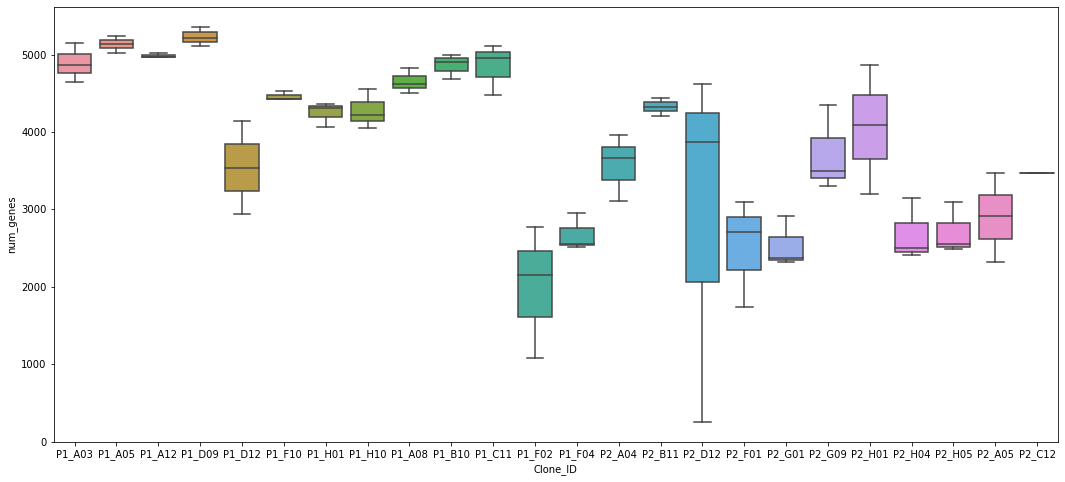

In [28]:
nG = nGene(EM_raw, meta_df)

In [29]:
nG_max = nG.groupby('Clone_ID').apply(np.max).num_genes
nG_min = nG.groupby('Clone_ID').apply(np.min).num_genes
clonepops = meta_df.Clone_ID.value_counts()

In [30]:
clones_good = [clone for clone in clones if nG_max[clone] - nG_min[clone] <= 1000]
clones_good = [clone for clone in clones_good if clonepops[clone] == 3]
print('{} clones remaining after {} crazy clones removed.'.format(len(clones_good), len(clones) - len(clones_good)))
bulks_good = [bulk for bulk in bulks if meta_df.loc[bulk].Clone_ID in clones_good]

16 clones remaining after 8 crazy clones removed.


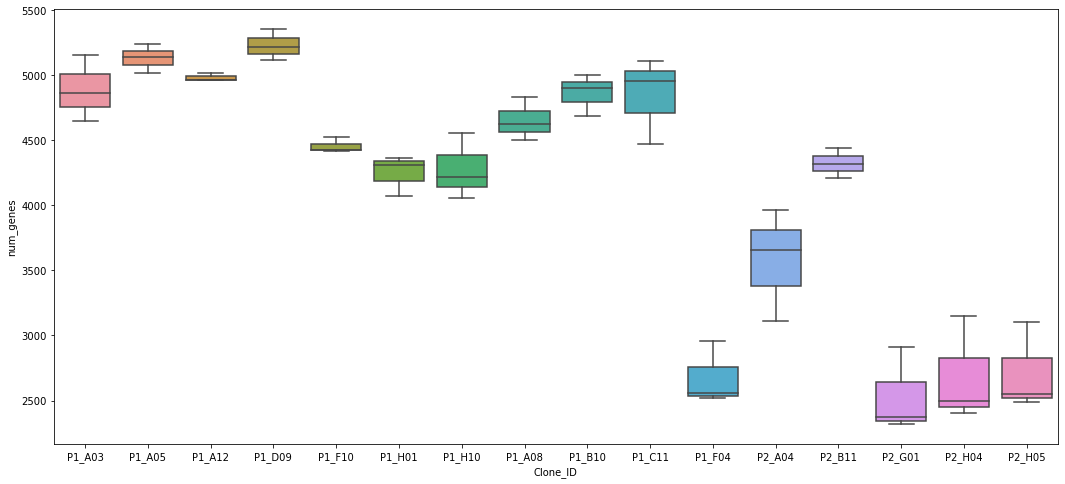

In [31]:
nG = nGene(EM_raw.loc[bulks_good], meta_df.loc[bulks_good]) # Post-trimming violin-plot.

### Clipping and log-normalization

Now we normalize our gene expression matrix.  We only use the good bulks and clones.  We cut off all negative gene-expression, and normalize the gene expression on a log-scale.  In the end, a gene-expression value of $x$ will be replaced by $\log(1 + max(x,0))$ (natural logarithm).

In [32]:
def log2p(x):
    return np.log1p(x) / np.log(2) # For later use.

In [33]:
EM = EM_raw[genes_relevant].copy()  # Only use relevant genes.
#  EM = EM.loc[bulks_good] # Only use good cells.
EM.clip(0, inplace = True) # Clip any negative values to zero.
EM = EM.transform(log2p) # Apply log(1+x) transform.

Now we examine the zeros (dropouts) and means in this matrix.  For each gene, we look at two quantities:  the *nonzero ratio* is the proportion of cells which express the gene (above the cutoff).  The *mean nonzero* is the mean of the (log-normalized) expression of the gene, restricting to the expressions above the cutoff.

The following function creates a dataframe with the nonzero ratio and mean nonzero value for every gene, using a given cutoff.  By default, the cutoff should be given in "absolute" terms, i.e., before log-normalization.  A cutoff of 10 seems reasonable.

In [34]:
def dropmean(df, cutoff, absolute=True):
    behave_df = df.copy()
    no_cells = len(behave_df)
    max_expression = behave_df.max()
    if absolute:
        co = log2p(cutoff)
    else:
        co = cutoff
    behave_df = behave_df.clip(co,max(max_expression))
    dropout_df = behave_df.apply(lambda column: ((column > co).sum()) / no_cells )
    meannz_df = behave_df.apply(lambda column: column.replace(co, np.nan).mean())
    dm_df = pd.concat([dropout_df, meannz_df], axis=1)
    dm_df = dm_df.rename(columns={0: "Nonzero Ratio", 1: "Mean nonzero"})
    return dm_df

To choose a reasonable cutoff, one can begin with a cutoff of zero, then increase the cutoff until the graph below loses the blob at the bottom right.  In other words, we should not find a clump of genes with very high nonzero ratio and low mean nonzero value.

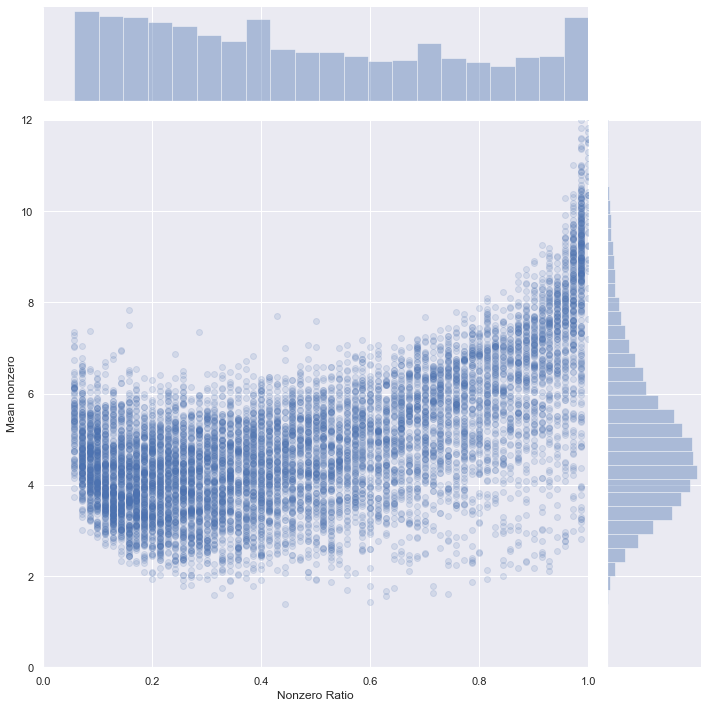

In [35]:
dm_df = dropmean(EM, 0) # Begin with cutoff at zero.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,12), height=10)

The bulks here have 25 cells each.  Therefore, to get a 0-count for a gene, it means that 25 cells all have to register a 0-count.  Even if each cell has a low probability of nonzero gene expression (e.g. 10%), there is still a high probability that the bulk will have a nonzero gene expression (e.g. 93%).  If $Z_{sc}$ is the single-cell zero probability, and $Z_{bulk}$ is the bulk zero probability, then they are related by the formula
$$Z_{bulk} = Z_{sc}^{25}.$$
Therefore $Z_{sc}$ can be inferred from the bulk zero ratio, by
$$Z_{sc} = \sqrt[25]{Z_{bulk}}.$$

The nonzero gene expression for a 25-cell bulk is affected by the zeros occurring in the single cells within the bulk.  If $M_{sc}$ is the mean nonzero gene expression for single cells within a bulk, then the gene expression of the bulk is given by
$$M_{bulk} = M_{sc} * (1 - Z_{sc}).$$
Therefore the bulk gene expression can be used to find the mean gene expression for single cells, by the formula

$$M_{sc} = \frac{M_{bulk}}{1 - Z_{sc}} = \frac{M_{bulk}}{1 - \sqrt[25]{Z_{bulk}}}.$$

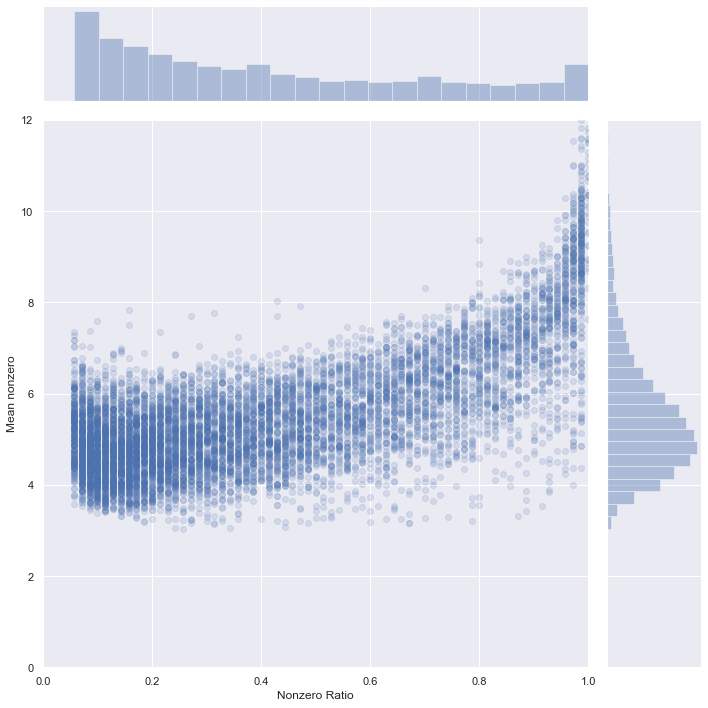

In [36]:
dm_df = dropmean(EM, 5) # Now impose a cutoff of 5.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,12), height=10)

The 5-count cutoff effectively removed the heavy blob of genes on the bottom-right.

In [37]:
EM.to_pickle('P9855_EM.pkl') # Save file as a pickle.  This will be used for downstream analysis.
print('Expression matrix pickled, with shape {}'.format(EM.shape)) 

Expression matrix pickled, with shape (70, 9587)


In [38]:
len(genes_relevant)

9587

In [39]:
meta_df.head()

,Number_Of_Cells,Clone_ID
Sample_ID,,
P9855_2001,25,P1_A03
P9855_2002,25,P1_A03
P9855_2003,25,P1_A03
P9855_2004,25,P1_A05
P9855_2005,25,P1_A05


# Clonally significant genes

Here we use the expression matrix to identify the genes which are differentially expressed between clones.  We use a simple ANOVA F-statistic to measure clonal variation (relative to overal variation), with associated p-value.  To validate the process, we randomly permute the clone labels to see the resulting distribution of p-values.

In [40]:
len(bulks)

70

In [41]:
wh3 = (meta_df.Clone_ID.value_counts() == 3)
E_3clones = wh3[wh3].index
E_3samples = [bulk for bulk in bulks if meta_df.Clone_ID[bulk] in E_3clones]
EM_3 = EM.loc[E_3samples]
print('{} samples belong to the {} 3-sample clones.'.format(len(E_3samples), len(E_3clones)))

69 samples belong to the 23 3-sample clones.


In [42]:
import scipy.stats as ss

EM_var = pd.DataFrame(index = EM_3.columns)
N = len(EM_3)
K = len(E_3clones)
EM_varwithin = (2 / (N-K)) * EM_3.groupby(meta_df.Clone_ID).var().sum()
EM_clonal = EM_3.groupby(meta_df.Clone_ID).mean()
EM_vargroup = 3*EM_clonal.var()
EM_var['F'] = EM_vargroup / EM_varwithin
EM_var['p'] = pd.Series(ss.f.sf(EM_var['F'], N-1, K-1), index=EM_var.index)
EM_var['logp'] = -np.log10(EM_var['p'])
EM_var.head()

,F,p,logp
ENSG00000000419,1.028906,0.491184,0.308756
ENSG00000000457,1.033881,0.485703,0.313629
ENSG00000000460,1.224516,0.304779,0.516014
ENSG00000001036,2.076253,0.028856,1.539770
ENSG00000001084,0.930641,0.605065,0.218198


Here are the top fifty genes, by clonal significance.

In [43]:
sig_genes = pd.DataFrame(EM_var['logp'].sort_values(ascending=False))
sig_genes['name'] = gene_df['Gene_name']
sig_genes[:50]

,logp,name
ENSG00000115523,13.376101,GNLY
ENSG00000163106,10.212311,HPGDS
ENSG00000240403,9.963162,KIR3DL2
ENSG00000196154,9.443148,S100A4
ENSG00000056736,9.084253,IL17RB
ENSG00000145649,9.003821,GZMA
ENSG00000113088,8.713514,GZMK
ENSG00000131153,8.136405,GINS2
ENSG00000143184,7.778565,XCL1
ENSG00000102048,7.637218,ASB9


Now we permute the clone labels to see how it affects clonal significance.

In [44]:
clone_shuff = meta_df.loc[E_3samples].copy()
clone_shuff['Clone_ID'] = np.random.permutation(clone_shuff['Clone_ID'])
clone_shuff = clone_shuff['Clone_ID']
EM_var_shuff = pd.DataFrame(index = EM_3.columns)
N = len(EM_3)
K = len(E_3clones)
EM_varwithin = (2 / (N-K)) * EM_3.groupby(clone_shuff).var().sum()
EM_clonal = EM_3.groupby(clone_shuff).mean()
EM_vargroup = 3*EM_clonal.var()
EM_var_shuff['F'] = EM_vargroup / EM_varwithin
EM_var_shuff['p'] = pd.Series(ss.f.sf(EM_var_shuff['F'], N-1, K-1), index=EM_var_shuff.index)
EM_var_shuff['logp'] = -np.log10(EM_var_shuff['p'])
EM_var_shuff.head()

,F,p,logp
ENSG00000000419,0.710761,0.856471,0.067288
ENSG00000000457,1.152245,0.366306,0.436156
ENSG00000000460,1.434411,0.173225,0.761389
ENSG00000001036,0.875396,0.671761,0.172785
ENSG00000001084,1.269268,0.271074,0.566911


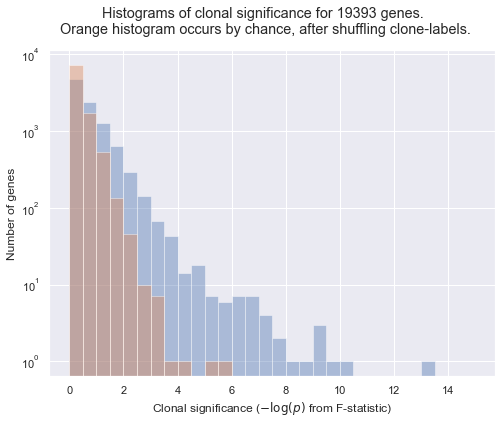

In [45]:
fig,ax = plt.subplots(figsize=(8,6))
bins = np.arange(0,15.1,0.5)
sns.distplot(EM_var['logp'], bins = bins, kde=False)
sns.distplot(EM_var_shuff['logp'], bins=bins, kde=False)
ax.set_xlabel('Clonal significance ($-\log(p)$ from F-statistic)')
ax.set_ylabel('Number of genes')
plt.yscale('log')
plt.suptitle('Histograms of clonal significance for {} genes. \n'
            'Orange histogram occurs by chance, after shuffling clone-labels.'.format(len(genes)))
plt.show()

We can see a pronounced excess of clonally significant genes in the real data (blue bars), as compared to randomly permuted clone labels (orange bars).  Note the log-scale on the y-axis!